In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content/drive/MyDrive/Colab Notebooks/project'

/content/drive/MyDrive/Colab Notebooks/project


In [3]:
import pandas as pd
import os
import re
import numpy as np

In [4]:
data=pd.read_csv('./face2bmi/full.csv')
data.head()

,nameid,name,book_date,city,holding_location,age,height,weight,race,sex,eyes,hair,bookid
0,7482,JAMES DEYO ROBINSON,3/10/2017 10:05:55 AM,"WAUKEE, IA",PCJ,54,"5' 11""",280,Black,Male,Brown,Black,248038
1,754952,CORDERRO ALTON LAURENCE,4/23/2017 8:57:43 AM,"DES MOINES, IA",Cherokee Mental Health,26,"5' 11""",210,Black,Male,Brown,Black,250464
2,644421,TAYLOR LOUIS HARLAN,12/7/2017 4:00:07 PM,"DES MOINES, IA",PCJ,24,"5' 09""",290,White,Male,Green,Blonde,263711
3,699804,MALIK TYRONE MANDUJANO,4/1/2018 3:24:44 AM,"DES MOINES, IA",PCJ,21,"5' 03""",130,Black,Male,Brown,Black,270020
4,238047,DUSTIN GLEN BLACK,8/5/2018 9:26:54 PM,"DES MOINES, IA",PCJ,29,"6' 02""",230,White,Male,Blue,Blonde,277774


In [5]:
regex_feet=re.compile('([0-9]+)\'')
regex_inches=re.compile('([0-9]+)\"')

def extract_numbers(x, regex):
  captures=regex.findall(x)
  if len(captures)>0:
    try:
      return int(captures[0])
    except:
      return None
  else:
    return None

data['feet']=data['height'].map(lambda i: extract_numbers(i, regex_feet))
data['inches']=data['height'].map(lambda i: extract_numbers(i,regex_inches))
data.loc[data.inches>12,:]

,nameid,name,book_date,city,holding_location,age,height,weight,race,sex,eyes,hair,bookid,feet,inches
31,1083884,CALEB CHARLES RUTAN,1/2/2019 6:27:40 AM,"DES MOINES, IA",PCJ,48,"6' 63""",200,White,Male,Brown,Gray,287593,6.0,63.0
456,912542,HUSSEIN NKUSU TAMBWE,7/4/2019 10:40:46 AM,"URBANDALE, IA",PCJ,24,"5' 57""",175,Black,Male,Brown,Black,296374,5.0,57.0
566,1169382,JULIANNE JO BECKETT,7/15/2019 4:50:55 PM,"KNOXVILLE, IA",PCJ,20,"5' 59""",350,White,Female,Hazel,Brown,296977,5.0,59.0
622,1227456,ANDREW LANTA BOYD,7/19/2019 8:11:17 AM,"DES MOINES, IA",PCJ,35,"5' 59""",0,Black,Male,Brown,Black,297206,5.0,59.0
640,877215,SIOUX HAWK HOFFNER,7/22/2019 6:51:56 PM,"DES MOINES, IA",PCJ,24,"4' 49""",90,Pacific Islander,Female,Brown,Brown,297380,4.0,49.0
671,1051124,JASON ALLAN BROWNING,7/24/2019 6:10:24 PM,"URBANDALE, IA",PCJ,41,"6' 60""",205,White,Male,Green,Brown,297503,6.0,60.0
1068,1012250,DARRYL ANTHONY HISHAW,10/6/2019 4:48:50 PM,"DES MOINES, IA",PCJ,26,"5' 56""",145,Black,Male,Brown,Black,301966,5.0,56.0
1192,1170588,KAY SAW,10/27/2019 4:21:49 PM,"DES MOINES, IA",PCJ,22,"5' 54""",120,Asian,Male,Brown,Black,303124,5.0,54.0


In [6]:
# found some incorrect inches, assume 63" to 6.3"
data['inches'] = data['inches'].map(lambda i: i / 10 if i > 12 else i)
# convert feet/inches to inches
data['height'] = data.apply(lambda row: row['feet'] * 12 + row['inches'], axis=1)
# covert inches to cm
data['height'] = data['height'].map(lambda i: i * 2.54 )
# weight pounds => kg
data['weight'] = data['weight'].map(lambda i: i * 0.453592)
# calculate BMI = weight/height^2
data['bmi'] = data.apply(lambda row: row['weight'] / ((row['height']/100)**2), axis = 1)
# create gender (number format of sex)
data['gender'] = data['sex'].map(lambda i: 1 if i == 'Male' else 0)

# data[['nameid','age','height','weight','sex', 'bmi']]
prepro_data=data[['nameid','age','height','weight','sex', 'bmi']]
prepro_data

,nameid,age,height,weight,sex,bmi
0,7482,54,180.34,127.00576,Male,39.051641
1,754952,26,180.34,95.25432,Male,29.288731
2,644421,24,175.26,131.54168,Male,42.825039
3,699804,21,160.02,58.96696,Male,23.028211
4,238047,29,187.96,104.32616,Male,29.529925
...,...,...,...,...,...,...
1550,1260914,33,162.56,77.11064,Male,29.180110
1551,2365,50,177.80,92.98636,Male,29.414111
1552,1056459,43,167.64,104.32616,Female,37.122560
1553,235985,58,157.48,90.71840,Female,36.580073


In [7]:
prepro_data.to_csv('./face2bmi/preprocessing_data.csv',index=False)

In [8]:
# remove rows that no face images
data['index'] = data['bookid'].map(lambda i: str(i) +'.jpg')
allimage = os.listdir('./face')
data = data.loc[data['index'].isin(allimage),:]

# remove rows with invalid BMI
data = data.loc[~data['bmi'].isnull(), :]

# split train/valid
in_train = np.random.random(size = len(data)) <= 0.8
train = data.loc[in_train,:]
test = data.loc[~in_train,:]

print('train data dimension: {}'.format(str(train.shape)))
print('test data dimension:  {}'.format(str(test.shape)))

# output to csv files
train.to_csv('./face2bmi/train.csv', index = False)
test.to_csv('./face2bmi/valid.csv', index = False)

train data dimension: (1218, 18)
test data dimension:  (325, 18)


In [9]:
!pip install mtcnn
!pip install opencv-python
!pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
from mtcnn.mtcnn import MTCNN
import cv2
import os

test_dir='./face2bmi/single_face/'
train_dir='./face'
test_processed_dir='./face2bmi/test_aligned'
train_processed_dir='./face2bmi/train_aligned'

os.listdir(test_dir)

['iu.jpg']

In [11]:
img = cv2.cvtColor(cv2.imread(test_dir+'/iu.jpg'), cv2.COLOR_BGR2RGB)
detector = MTCNN()
print(detector.detect_faces(img))
box = detector.detect_faces(img)[0]

1/1 [==============================] - 0s 307ms/step
[{'box': [249, 94, 267, 372], 'confidence': 0.9977633953094482, 'keypoints': {'left_eye': (313, 240), 'right_eye': (441, 232), 'nose': (380, 315), 'mouth_left': (337, 385), 'mouth_right': (433, 382)}}]
1/1 [==============================] - 0s 40ms/step


In [12]:
!pip install keras_vggface
!pip install keras_applications
!pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
# from tensorflow.keras.preprocessing.image import load_img
from keras.utils import load_img, img_to_array
from keras_vggface import utils
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

def crop_img(im,x,y,w,h):
    return im[y:(y+h),x:(x+w),:]

def detect_face(face_path):
    img = cv2.cvtColor(cv2.imread(face_path), cv2.COLOR_BGR2RGB)
    box = detector.detect_faces(img)[0]
    return box

def detect_faces(face_path):
    #img = cv2.cvtColor(cv2.imread(face_path), cv2.COLOR_BGR2RGB)
    # img = image.load_img(face_path)
    # img = image.img_to_array(img)
    img = load_img(face_path)
    img = img_to_array(img)
    box = detector.detect_faces(img)
    return box

def draw_box(face_path, plot = True):
    
    boxes = detect_faces(face_path)
    im = np.array(Image.open(face_path), dtype=np.uint8)
    
    if plot:
        # Create figure and axes
        num_box = len(boxes)
        fig,ax = plt.subplots(1, (1 + num_box))
        fig.set_size_inches(5 * (1 + num_box),5)
        # Display the image
        ax[0].imshow(im)
        ax[0].axis('off')
        # Create a Rectangle patch
        for idx, box in enumerate(boxes):
            box_x, box_y, box_w, box_h = box['box']
            rect = patches.Rectangle((box_x, box_y), box_w, box_h, linewidth=1,edgecolor='r',facecolor='none')
            ax[0].add_patch(rect)
            ax[0].text(box_x, box_y, '{:3.2f}'.format(box['confidence']))
            for i in box['keypoints'].keys():
                circle = patches.Circle(box['keypoints'][i], radius = 5, color = 'red')
                ax[0].add_patch(circle)
            ax[1 + idx].imshow(crop_img(im, *box['box']))
            ax[1 + idx].axis('off')
        plt.show()
    
    res = [crop_img(im, *box['box']) for box in boxes]
    
    return res

# from keras.utils.layer_utils import get_source_inputs 으로 오류난 부분 수정.


1/1 [==============================] - 0s 17ms/step


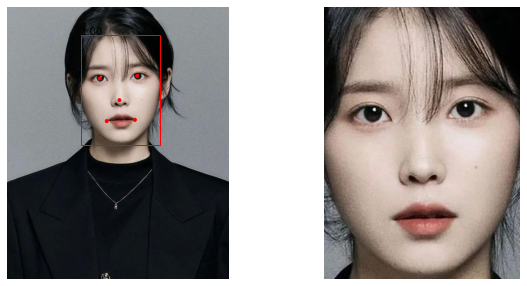

In [14]:
res = draw_box(test_dir + 'iu.jpg')

In [15]:
def cut_negative_boundary(box):
    res = []
    for x in box['box']:
        if x < 0:
            x = 0
        res.append(x)
    box['box'] = res
    return box

In [16]:
# from tqdm import tqdm
# import shutil

# if os.path.exists(train_processed_dir):
#     shutil.rmtree(train_processed_dir)
# os.mkdir(train_processed_dir)
# for img in tqdm(os.listdir(train_dir)):
#     try:
#         box = detect_face(train_dir+ '/' + img)
#         box = cut_negative_boundary(box)
#         im = plt.imread(train_dir+ '/' + img)
#         cropped = crop_img(im, *box['box'])
#         plt.imsave(train_processed_dir+ '/' + img, cropped)
#     except:
#         print(img)
#         continue

In [17]:
mode = 'train' #'train' or 'predict'
model_type = 'vgg16'
model_tag = 'base'
model_id = '{:s}_{:s}'.format(model_type, model_tag)
model_dir = './face2bmi/saved_model/model_{:s}.h5'.format(model_id)
# model_dir = './model_{:s}.h5'.format(model_id)로 설정해보기
bs = 8
epochs = 2
freeze_backbone = True # True => transfer learning; False => train from scratch

In [18]:
import pandas as pd
import os
import json
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
from face2bmi_models import FacePrediction
import glob

alimages = os.listdir('./face2bmi/train_aligned')
train = pd.read_csv('./face2bmi/train.csv')
valid = pd.read_csv('./face2bmi/valid.csv')

train = train.loc[train['index'].isin(alimages)]
valid = valid.loc[valid['index'].isin(alimages)]

In [19]:
# create metrics, model dirs
Path('./face2bmi/metrics').mkdir(parents = True, exist_ok = True)
Path('./face2bmi/saved_model').mkdir(parents = True, exist_ok = True)

In [20]:
es = EarlyStopping(patience=3)
ckp = ModelCheckpoint(model_dir, save_best_only=True, save_weights_only=True, verbose=1)
tb = TensorBoard('./tb/%s'%(model_id))
callbacks = [es, ckp]

model = FacePrediction(img_dir = './face2bmi/train_aligned', model_type = model_type)
model.define_model(freeze_backbone = freeze_backbone)
# model.model.summary()
if mode == 'train':
  model_history = model.train(train, valid, bs = bs, epochs = epochs, callbacks = callbacks)
else:
  model.load_weights(model_dir)

Epoch 1/2


/content/drive/MyDrive/Colab Notebooks/project/face2bmi_models.py:155: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  callbacks=callbacks)


152/152 [==============================] - ETA: 0s - loss: 19.3885 - bmi_loss: 20.6579 - age_loss: 28.4189 - sex_loss: 0.2027 - sex_accuracy: 0.9219
Epoch 1: val_loss improved from inf to 11.24819, saving model to ./face2bmi/saved_model/model_vgg16_base.h5
152/152 [==============================] - 21s 111ms/step - loss: 19.3885 - bmi_loss: 20.6579 - age_loss: 28.4189 - sex_loss: 0.2027 - sex_accuracy: 0.9219 - val_loss: 11.2482 - val_bmi_loss: 11.6913 - val_age_loss: 18.8466 - val_sex_loss: 0.1052 - val_sex_accuracy: 0.9656
Epoch 2/2
152/152 [==============================] - ETA: 0s - loss: 7.3059 - bmi_loss: 7.5033 - age_loss: 12.9575 - sex_loss: 0.0756 - sex_accuracy: 0.9737
Epoch 2: val_loss improved from 11.24819 to 5.51637, saving model to ./face2bmi/saved_model/model_vgg16_base.h5
152/152 [==============================] - 12s 78ms/step - loss: 7.3059 - bmi_loss: 7.5033 - age_loss: 12.9575 - sex_loss: 0.0756 - sex_accuracy: 0.9737 - val_loss: 5.5164 - val_bmi_loss: 6.0236 - val

In [21]:
# from tqdm import tqdm
# import shutil
# if os.path.exists(test_processed_dir):
#     shutil.rmtree(test_processed_dir)
# os.mkdir(test_processed_dir)
# for img in tqdm(os.listdir(test_dir)):
#     box = detect_face(test_dir+'/'+img)
#     im = plt.imread(test_dir+'/'+img)
#     cropped = crop_img(im, *box['box'])
#     plt.imsave(test_processed_dir+'/'+img, crop_img(im, *box['box']))

iu.jpg
1/1 [==============================] - 1s 910ms/step


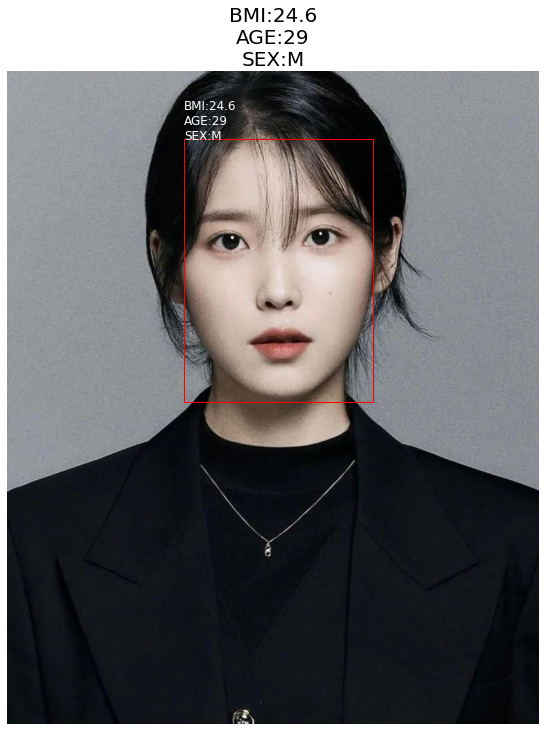

[[array([[24.577265]], dtype=float32),
  array([[29.345915]], dtype=float32),
  array([[0.48130703]], dtype=float32)]]

In [22]:
g = os.listdir(test_dir)
g = [file for file in g if file.endswith(".jpg")][0]
print(g)
model.predict_faces(test_dir+g, show_img=True)

In [23]:
model.predict_df('./face2bmi/test_aligned')

1/1 [==============================] - 0s 32ms/step


,img,bmi,age,sex,sex_prob
0,iu.jpg,24.862719,29.318449,Male,0.418903


1/1 [==============================] - 0s 21ms/step


TypeError: ignored

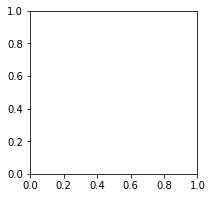

In [24]:
# preds = model.predict('./face2bmi/test_aligned/', show_img = True)